In [26]:
import osmnx as ox
import pandana
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as npm
import seaborn as sns

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

In [35]:
# Select city (COP, HEL, WAR)
city = 'WAR'
crs = 3035

if city == 'COP':
    cityname = 'Copenhagen, Denmark'
    minx, miny, maxx, maxy = 12.42000, 55.61000, 12.65000, 55.78000
elif city == 'HEL':
    cityname = 'Helsinki, Finland'
    minx, miny, maxx, maxy = 24.82345, 60.14084, 25.06404, 60.29496
elif city == 'WAR':
    cityname = 'Warsaw, Poland'
    minx, miny, maxx, maxy = 20.79057, 52.09901, 21.31300, 52.38502

/home/gispo_user/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Get graph by geocoding
try:
    graph = ox.graph_from_place(cityname, network_type="walk")
    ignore_geocoding = False
    
# Get graph based on bbox if geocoding fails (copenhagen has no polygon on nominatim)
except ValueError:
    graph = ox.graph_from_bbox(maxy, miny, maxx, minx, network_type="walk")
    ignore_geocoding = True
    
graph = ox.projection.project_graph(graph, to_crs=crs)

In [5]:
# Select points of interest based on osm tags
tags = {
    'amenity':[
        'cafe',
        'bar',
        'pub',
        'restaurant'
    ],
    'shop':[
        'bakery',
        'convenience',
        'supermarket',
        'mall',
        'department_store',
        'clothes',
        'fashion',
        'shoes'
    ],
    'leisure':[
        'fitness_centre'
    ]
}

# Get amentities from place/bbox
if ignore_geocoding == True:
    amenities = ox.geometries.geometries_from_bbox(
        maxy, miny, maxx, minx,
        tags=tags
    )
    
else:
    amenities = ox.geometries.geometries_from_place(
        cityname,
        tags=tags
    )
    
# Project amenities
amenities = amenities.to_crs(epsg=crs)

In [4]:
# Max time to walk in minutes (no routing to nodes further than this)
walk_time = 15

# Walking speed
walk_speed = 4.5

# Set a uniform walking speed on every edge
for u, v, data in graph.edges(data=True):
    data['speed_kph'] = walk_speed

graph = ox.add_edge_travel_times(graph)

# Extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)
nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

# Extract a geometry version for plotting
edges_plt = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['geometry']]

In [6]:
# Save as gpkg
#amenities_point = amenities[amenities['geometry'].apply(lambda x: x.type=='Point')]
#amenities_point.to_file('amenities_'+city+'.gpkg', driver='GPKG')

/home/gispo_user/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# Construct the pandana network model
network = pandana.Network(
    node_x=nodes['x'],
    node_y=nodes['y'], 
    edge_from=edges['u'],
    edge_to=edges['v'],
    edge_weights=edges[['travel_time']]
)

# Extract centroids from the amenities' geometries
centroids = amenities.centroid

In [8]:
# Specify a max travel distance for analysis
# Minutes -> seconds
maxdist = walk_time * 60

# Set the amenities' locations on the network
network.set_pois(
    category='pois',
    maxdist=maxdist,
    maxitems=10,
    x_col=centroids.x, 
    y_col=centroids.y
)

/home/gispo_user/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [9]:
# calculate travel time to 10 nearest amenities from each node in network
distances = network.nearest_pois(
    distance=maxdist,
    category='pois',
    num_pois=10
)

distances.astype(int).head()

/home/gispo_user/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
26063726,289,372,495,516,537,569,579,632,666,693
31717945,302,352,475,496,517,549,559,638,673,683
4404880725,304,387,510,531,551,584,594,647,681,708
1868447591,266,387,511,532,552,577,594,609,680,709
1868447607,297,394,517,538,559,591,601,640,644,707


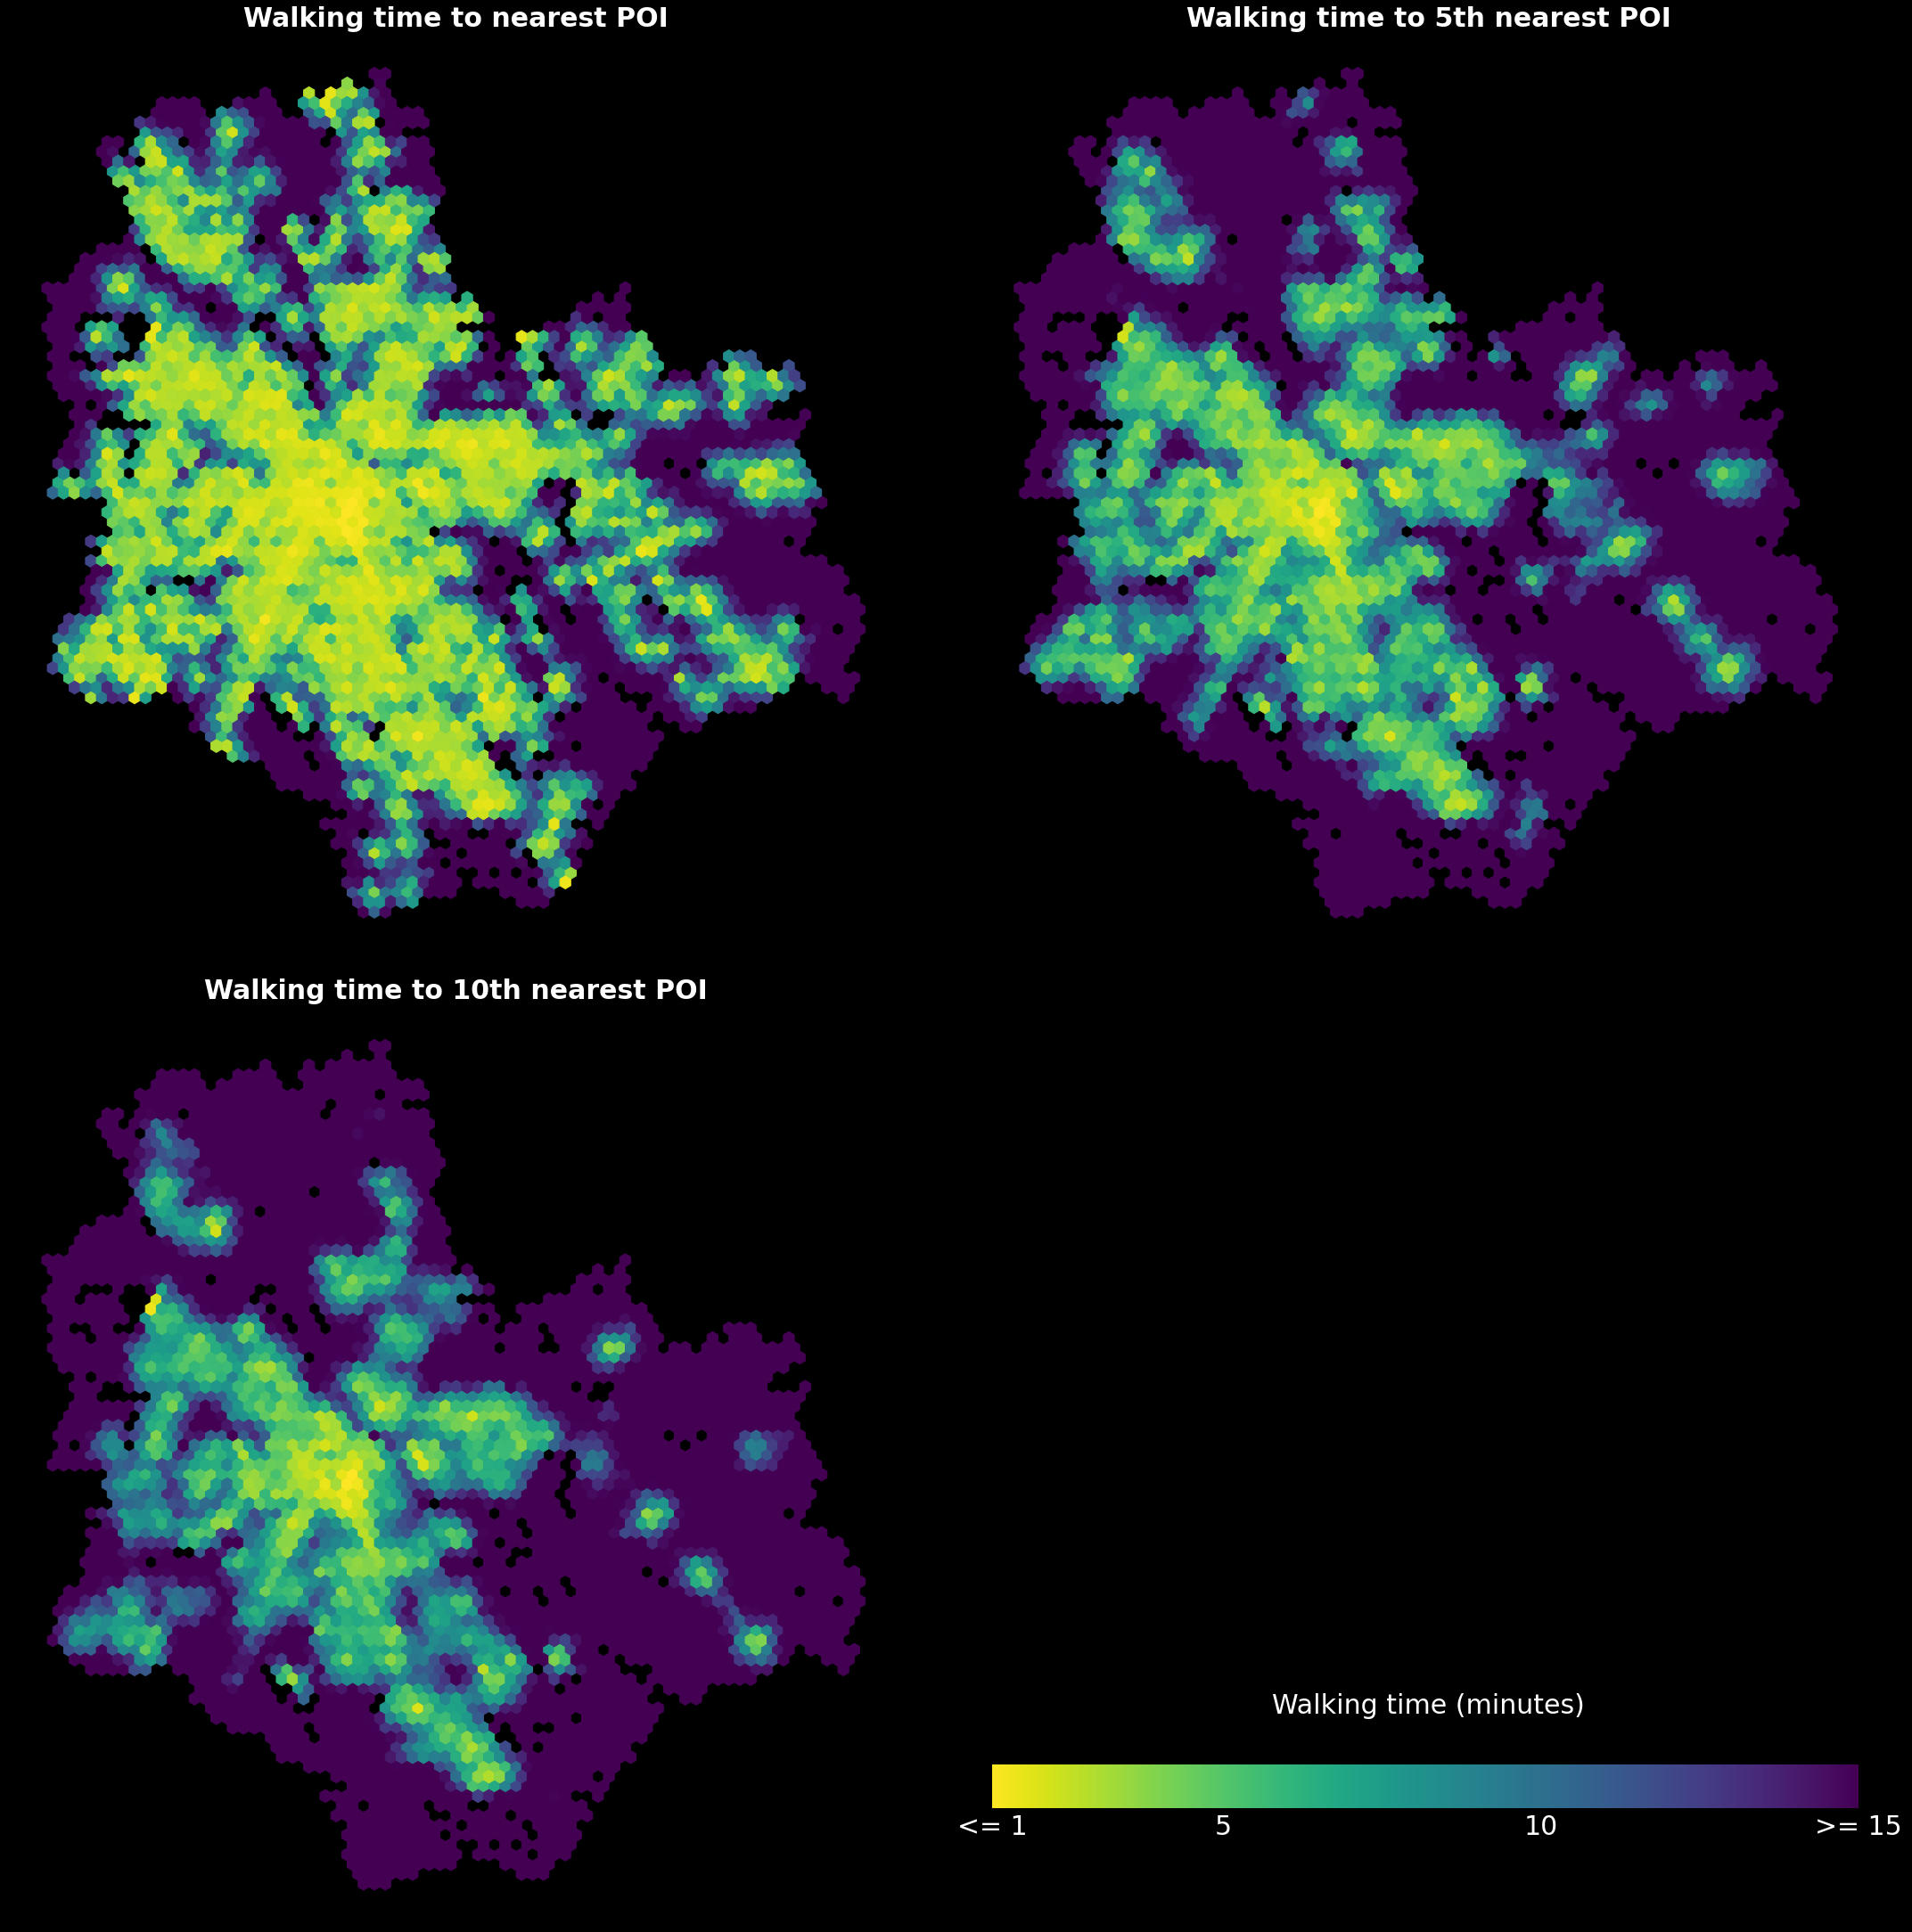

In [262]:
# Text to white
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Setup plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(30,30), constrained_layout=True)

ax[0][0].set_axis_off()
ax[0][1].set_axis_off()
ax[1][0].set_axis_off()
ax[1][1].set_axis_off()
ax[0][0].set_aspect('equal')
ax[0][1].set_aspect('equal')
ax[1][0].set_aspect('equal')
fig.set_facecolor('black')
cmap = 'viridis_r'

# Plot data
hb = ax[0][0].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[1],
    zorder=10,
    alpha=1
)

ax[0][0].set_title('Walking time to nearest POI', fontsize=30, fontweight='bold')

hb = ax[0][1].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[5],
    zorder=10,
    alpha=1
)

ax[0][1].set_title('Walking time to 5th nearest POI', fontsize=30, fontweight='bold')

hb = ax[1][0].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap=cmap,
    C=distances[10],
    zorder=10,
    alpha=1
)

ax[1][0].set_title('Walking time to 10th nearest POI', fontsize=30, fontweight='bold')

#ax[1][1].set_title('Walking time (minutes)', fontsize=30, pad=2)

# Add color bar
cbar_ax = fig.add_axes([0.5, 0.01, 0.5, 0.5])
cbar_ax.set_axis_off()

cb = plt.colorbar(
    hb,
    ax=cbar_ax,
    shrink=0.9,
    ticks=[82, 300, 600, 900],
    orientation='horizontal',
    aspect=20
)

cb.outline.set_edgecolor('none')

ax[1][1].text(0.5, 0.23, 'Walking time (minutes)', fontsize=30, ha='center')

cb.ax.tick_params(color='none', labelsize=30)
cb.ax.set_xticklabels(['<= 1', '5', '10', '>= 15'])
#cb.set_label('Average walking time (minutes)', fontsize=30)

#plt.tight_layout()
plt.savefig('./docs/walk_access_comparison.png', bbox_inches='tight')

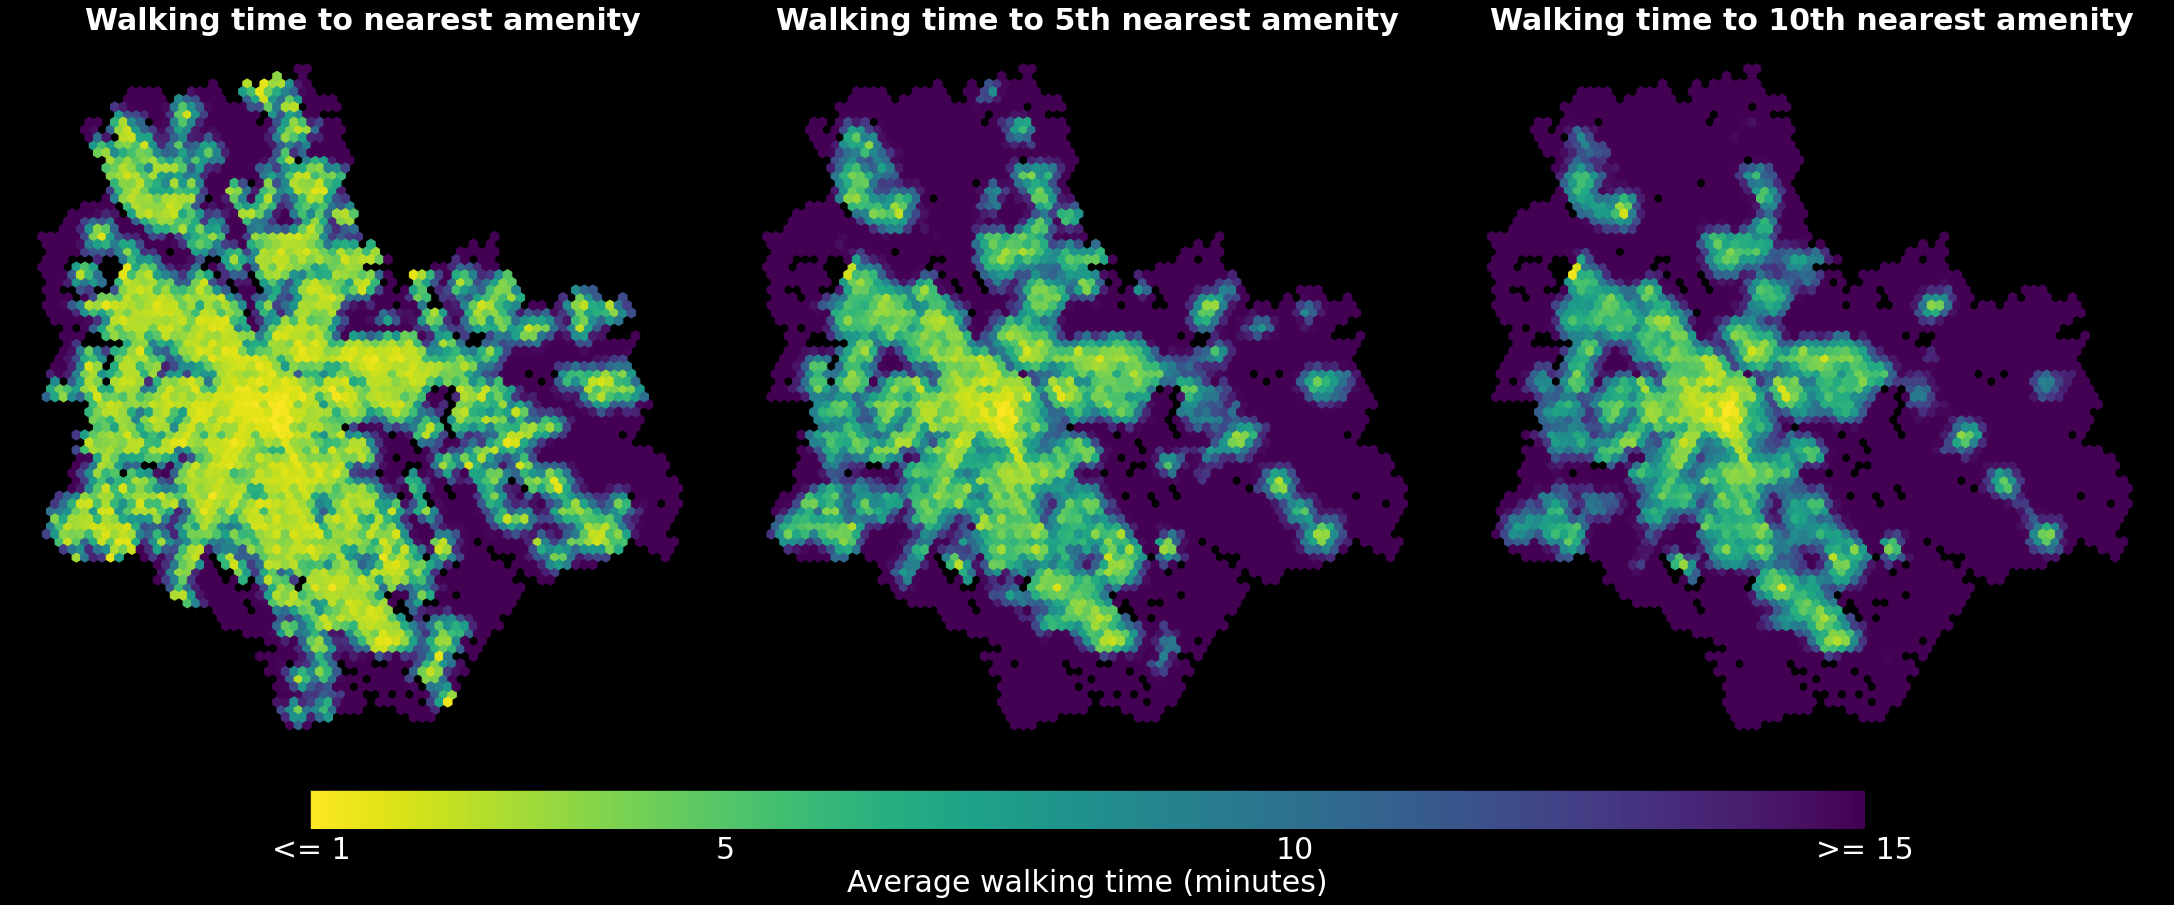

In [165]:
# Text to white
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Setup plot
fig, ax = plt.subplots(ncols=3, figsize=(30,12), constrained_layout=True)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
fig.set_facecolor('black')

# Plot data
hb = ax[0].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap='viridis_r',
    C=distances[1],
    zorder=10,
    alpha=1
)

ax[0].set_title('Walking time to nearest amenity', fontsize=30, fontweight='bold')

hb = ax[1].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap='viridis_r',
    C=distances[5],
    zorder=10,
    alpha=1
)

ax[1].set_title('Walking time to 5th nearest amenity', fontsize=30, fontweight='bold')

hb = ax[2].hexbin(
    x=nodes['x'],
    y=nodes['y'],
    gridsize=75,
    cmap='viridis_r',
    C=distances[10],
    zorder=10,
    alpha=1
)

ax[2].set_title('Walking time to 10th nearest amenity', fontsize=30, fontweight='bold')

# Add color bar
cbar_ax = fig.add_axes([0, 0, 1, 0.3])
cbar_ax.set_axis_off()

cb = plt.colorbar(
    hb,
    ax=cbar_ax,
    shrink=0.8,
    ticks=[82, 300, 600, 900],
    orientation='horizontal',
    aspect=40
)

cb.ax.tick_params(color='none', labelsize=30)
cb.ax.set_xticklabels(['<= 1', '5', '10', '>= 15'])
cb.set_label('Average walking time (minutes)', fontsize=30)

#plt.tight_layout()
#plt.savefig('./docs/walk_access_comparison.png', bbox_inches='tight')

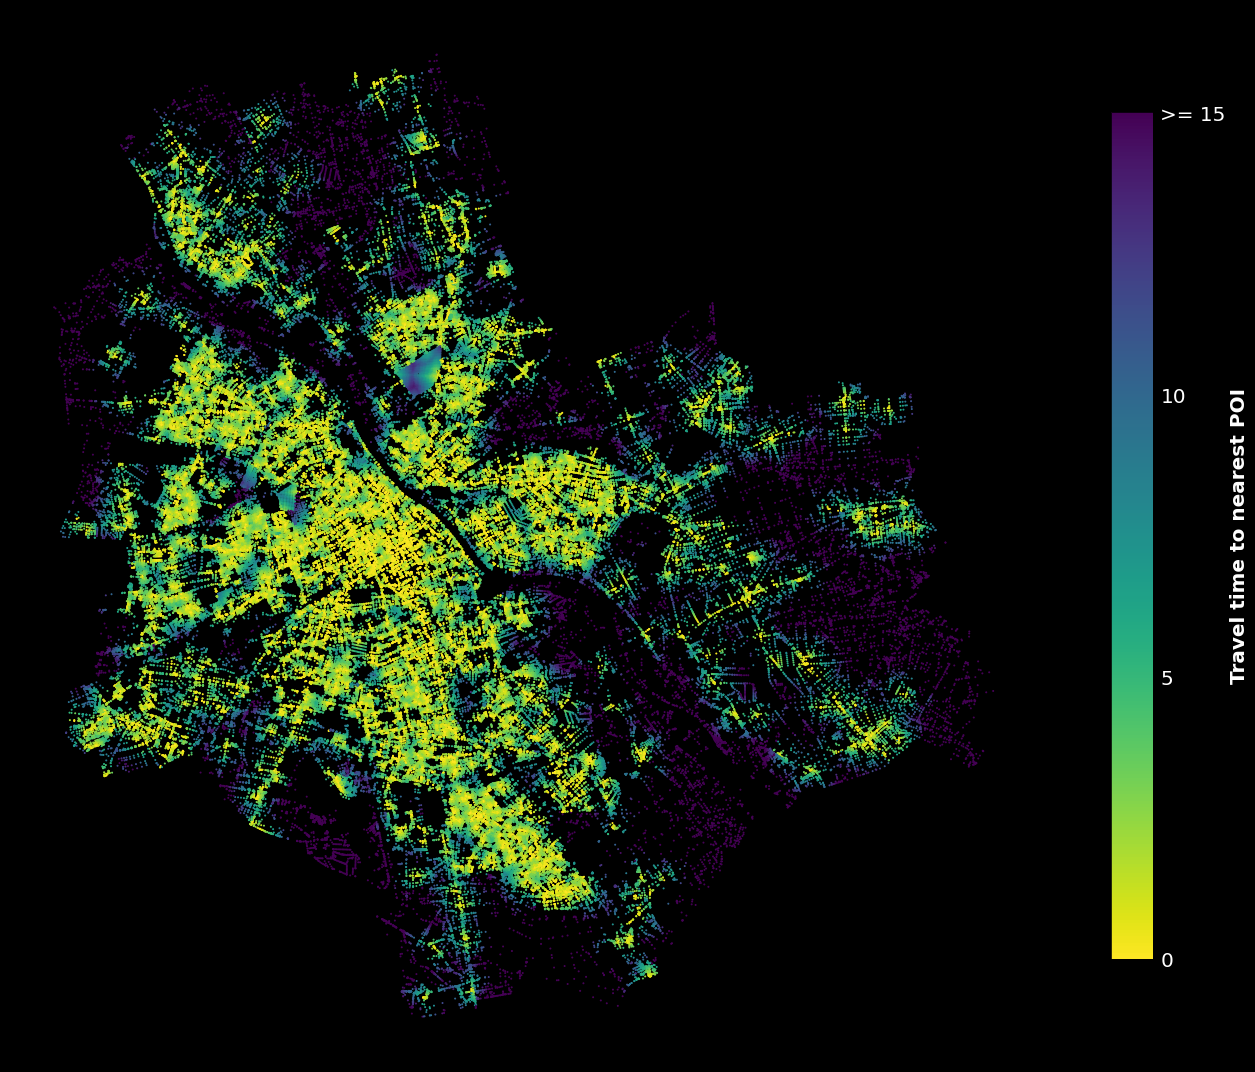

In [274]:
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Setup plot
fig, ax = plt.subplots(figsize=(20,15))
ax.set_axis_off()
ax.set_aspect('equal')
fig.set_facecolor((0,0,0))

# Plot distance to nearest amenity
sc = ax.scatter(
    x=nodes['x'],
    y=nodes['y'], 
    c=distances[1],
    s=1,
    cmap='viridis_r',
)

cb = fig.colorbar(sc, ax=ax, shrink=0.8, ticks=[0, 300, 600, 900])
cb.ax.tick_params(color='none', labelsize=20)
cb.ax.set_yticklabels(['0', '5', '10', '>= 15'])
cb.set_label('Travel time to nearest POI', fontsize=20, fontweight='bold')

plt.tight_layout()

plt.savefig(
    './docs/walk_access.png',
    #bbox_inches='tight'
)

In [11]:
# check data
distances.head()

,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
26063726,289.600006,372.299988,495.799988,516.799988,537.000000,569.599976,579.400024,632.900024,666.299988,693.799988
31717945,302.100006,352.299988,475.799988,496.799988,517.000000,549.599976,559.400024,638.299988,673.799988,683.200012
4404880725,304.500000,387.200012,510.700012,531.700012,551.900024,584.500000,594.299988,647.799988,681.200012,708.700012
1868447591,266.600006,387.799988,511.299988,532.299988,552.500000,577.400024,594.900024,609.900024,680.799988,709.299988
1868447607,297.600006,394.399994,517.900024,538.900024,559.099976,591.700012,601.500000,640.900024,644.200012,707.700012


In [12]:
nodes.head()

/home/gispo_user/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,x,y
osmid,,
26063726,5.071758e+06,3.283941e+06
31717945,5.071782e+06,3.283936e+06
4404880725,5.071748e+06,3.283957e+06
1868447591,5.071762e+06,3.283912e+06
1868447607,5.071731e+06,3.283946e+06


In [13]:
# Get simplified nodes with wgs coords for output csv
graph_wgs = ox.projection.project_graph(graph, to_crs=4326)
nodes_wgs = ox.graph_to_gdfs(graph_wgs, edges=False)[['x', 'y']]

/home/gispo_user/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# Join travel time info to nodes
walk_access = nodes.join(distances, on='osmid', how='left')
walk_access_wgs = nodes_wgs.join(distances, on='osmid', how='left')

In [15]:
walk_access_wgs.head()

,x,y,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,,,
26063726,21.017454,52.152787,289.600006,372.299988,495.799988,516.799988,537.000000,569.599976,579.400024,632.900024,666.299988,693.799988
31717945,21.017799,52.152710,302.100006,352.299988,475.799988,496.799988,517.000000,549.599976,559.400024,638.299988,673.799988,683.200012
4404880725,21.017353,52.152943,304.500000,387.200012,510.700012,531.700012,551.900024,584.500000,594.299988,647.799988,681.200012,708.700012
1868447591,21.017454,52.152529,266.600006,387.799988,511.299988,532.299988,552.500000,577.400024,594.900024,609.900024,680.799988,709.299988
1868447607,21.017072,52.152869,297.600006,394.399994,517.900024,538.900024,559.099976,591.700012,601.500000,640.900024,644.200012,707.700012


In [16]:
# Save as CSV
#walk_access_wgs.to_csv('walk_access_'+city+'.csv', encoding='utf-8')

/home/gispo_user/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
